# Kiểm tra các model đã được training

In [1]:
!ls /kaggle/input/train-model-tsr

classifier_results_summary.csv	__output__.json
custom.css			resnet18_best.pth
efficientnetb0_best.pth		resnet18_train_log.csv
efficientnetb0_train_log.csv	__results___files
mobilenetv2_best.pth		__results__.html
mobilenetv2_train_log.csv	shufflenetv2_x1_0_best.pth
__notebook__.ipynb		shufflenetv2_x1_0_train_log.csv


# Dataset

In [2]:
!ls /kaggle/input/build-dataset-tsr/tt100k_crops

class_counts.csv   idx2label.json  test
dataset_stats.npz  label2idx.json  train


# Evaluation và Analysis

## BƯỚC 1 – Setup & Load model

In [2]:
# =========================================================
# 🧩 STEP 1 – SETUP & LOAD MODEL
# =========================================================
import os, json, torch
import numpy as np
import pandas as pd
from torchvision import transforms, datasets
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === Path ===
DATA_DIR = "./Dataset/Classify"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR  = os.path.join(DATA_DIR, "test")
MODEL_DIR = "./weight"

# === Load mapping ===
with open(os.path.join(DATA_DIR, "idx2label.json")) as f:
    idx2label = json.load(f)
num_classes = len(idx2label)
print(f"📦 Số class: {num_classes}")

# === Load stats ===
stats = np.load(os.path.join(DATA_DIR, "dataset_stats.npz"))
mean, std = stats["mean"], stats["std"]

# === Transforms (chuẩn hóa giống khi train) ===
test_tfms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# === Dataset & DataLoader ===
test_ds = datasets.ImageFolder(TEST_DIR, transform=test_tfms)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2)
print(f"✅ Test set: {len(test_ds)} ảnh | {len(test_ds.classes)} class")


FileNotFoundError: [Errno 2] No such file or directory: './Dataset/Classify/idx2label.json'

## BƯỚC 2 – Hàm Evaluate từng model

In [ ]:
# =========================================================
# 🧩 STEP 2 – HÀM EVALUATE MODEL (CÓ PARAMS + SIZE + DEVICE)
# =========================================================
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
import torch
import time 

def evaluate_model(model_path, model_name, device="cuda"):
    from torchvision import models

    # === Build model ===
    if "resnet18" in model_name:
        model = models.resnet18()
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    elif "mobilenetv2" in model_name:
        model = models.mobilenet_v2()
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)
    elif "efficientnetb0" in model_name:
        model = models.efficientnet_b0()
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)
    elif "shufflenetv2_x1_0" in model_name:
        model = models.shufflenet_v2_x1_0()
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    else:
        raise ValueError(f"❌ Unknown model {model_name}")

    # === Load weight ===
    state = torch.load(model_path, map_location=device)
    model.load_state_dict(state)
    model.to(device)
    model.eval()

    # === Thông tin model ===
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    model_size = os.path.getsize(model_path) / (1024 * 1024)  # MB

    preds_all, labels_all = [], []
    total_time, total_imgs = 0.0, 0

    # === Evaluation loop ===
    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc=f"Evaluating {model_name}"):
            imgs, labels = imgs.to(device), labels.to(device)

            # Đo thời gian inference
            if device == "cuda":
                start = torch.cuda.Event(enable_timing=True)
                end = torch.cuda.Event(enable_timing=True)
                start.record()
                outputs = model(imgs)
                end.record()
                torch.cuda.synchronize()
                total_time += start.elapsed_time(end) / 1000.0  # ms → s
            else:
                start_time = time.time()
                outputs = model(imgs)
                total_time += time.time() - start_time

            total_imgs += imgs.size(0)
            preds_all.extend(outputs.argmax(1).cpu().tolist())
            labels_all.extend(labels.cpu().tolist())

    # === Tính metrics ===
    acc = accuracy_score(labels_all, preds_all)
    prec = precision_score(labels_all, preds_all, average="macro", zero_division=0)
    rec = recall_score(labels_all, preds_all, average="macro", zero_division=0)
    f1 = f1_score(labels_all, preds_all, average="macro", zero_division=0)
    fps = total_imgs / total_time if total_time > 0 else 0

    return {
        "Model": model_name,
        "Device": device.upper(),
        "Parameters(M)": round(n_params / 1e6, 3),
        "Model_Size(MB)": round(model_size, 2),
        "Accuracy": round(acc, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1": round(f1, 4),
        "FPS": round(fps, 1)
    }, labels_all, preds_all


## BƯỚC 3 – Chạy evaluation cho tất cả model

In [ ]:
# =========================================================
# 🧩 STEP 3 – CHẠY EVALUATION TRÊN CPU
# =========================================================
models_to_eval = [
    ("resnet18_best.pth", "resnet18"),
    ("mobilenetv2_best.pth", "mobilenetv2"),
    ("efficientnetb0_best.pth", "efficientnetb0"),
    ("shufflenetv2_x1_0_best.pth", "shufflenetv2_x1_0")
]

devices = []
if torch.cuda.is_available():
    devices = ["cuda", "cpu"]
else:
    devices = ["cpu"]

eval_results = []
results_detail = {}

for dev in devices:
    print(f"\n🚀 Running evaluation on: {dev.upper()}")
    for fname, name in models_to_eval:
        path = os.path.join(MODEL_DIR, fname)
        res, labels_all, preds_all = evaluate_model(path, name, dev)
        eval_results.append(res)
        results_detail[f"{name}_{dev}"] = (labels_all, preds_all)

# === Tổng hợp kết quả ===
df_eval = pd.DataFrame(eval_results)
display(df_eval)



🚀 Running evaluation on: CPU


Evaluating shufflenetv2_x1_0: 100%|██████████| 145/145 [00:23<00:00,  6.23it/s]


,Model,Device,Parameters(M),Model_Size(MB),Accuracy,Precision,Recall,F1,FPS
0,resnet18,CPU,11.223,42.89,0.9862,0.9738,0.9615,0.9653,203.1
1,mobilenetv2,CPU,2.340,9.16,0.9867,0.9783,0.9623,0.9685,174.3
2,efficientnetb0,CPU,4.124,16.02,0.9909,0.9836,0.9780,0.9802,151.6
3,shufflenetv2_x1_0,CPU,1.347,5.31,0.9840,0.9666,0.9526,0.9566,405.4


OSError: Cannot save file into a non-existent directory: '/kaggle/working'

In [6]:
df_eval.to_csv("/home/pi5/TrafficSign/Results/evaluation_summary_gpu_cpu.csv", index=False)


## BƯỚC 4 – Phân tích so sánh kết quả

In [7]:
# =========================================================
# 🧩 STEP 4 – PHÂN TÍCH & SO SÁNH KẾT QUẢ (GPU vs CPU)
# =========================================================
import pandas as pd
import matplotlib.pyplot as plt

df_eval = pd.read_csv("/home/pi5/TrafficSign/Results/evaluation_summary_gpu_cpu.csv")

# === Chuẩn hóa ===
df_eval["Model"] = df_eval["Model"].str.lower()
df_eval["Device"] = df_eval["Device"].str.upper()

# === Gom nhóm ===
gpu_df = df_eval[df_eval["Device"] == "CUDA"].set_index("Model")
cpu_df = df_eval[df_eval["Device"] == "CPU"].set_index("Model")

# === Nếu không có GPU hoặc CPU thì cảnh báo sớm ===
if gpu_df.empty or cpu_df.empty:
    print("⚠️ Không đủ dữ liệu để so sánh GPU vs CPU.")
    print(f"GPU rows: {len(gpu_df)}, CPU rows: {len(cpu_df)}")
    display(df_eval)
else:
    # === So sánh chi tiết ===
    compare = gpu_df[["Accuracy", "F1", "FPS"]].join(cpu_df, lsuffix="_GPU", rsuffix="_CPU")

    compare["ΔAccuracy(%)"] = ((compare["Accuracy_GPU"] - compare["Accuracy_CPU"]) * 100).round(2)
    compare["ΔF1(%)"] = ((compare["F1_GPU"] - compare["F1_CPU"]) * 100).round(2)
    compare["ΔFPS(×)"] = (compare["FPS_GPU"] / compare["FPS_CPU"]).round(1)
    compare["Time_per_img(ms)_GPU"] = (1000 / compare["FPS_GPU"]).round(2)
    compare["Time_per_img(ms)_CPU"] = (1000 / compare["FPS_CPU"]).round(2)

    display(compare)

    compare.to_csv("/kaggle/working/eval_compare_gpu_cpu.csv")

    # =========================================================
    # 🔍 Biểu đồ trực quan
    # =========================================================
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    compare[["Accuracy_GPU", "Accuracy_CPU", "F1_GPU", "F1_CPU"]].plot.bar(
        ax=axes[0], color=["#007bff", "#d9534f", "#28a745", "#f0ad4e"]
    )
    axes[0].set_title("So sánh Accuracy & F1 (GPU vs CPU)")
    axes[0].set_ylabel("Score")
    axes[0].grid(axis="y", linestyle="--", alpha=0.5)

    compare[["FPS_GPU", "FPS_CPU"]].plot.bar(
        ax=axes[1], color=["#17a2b8", "#6c757d"]
    )
    axes[1].set_title("So sánh FPS (GPU vs CPU)")
    axes[1].set_ylabel("Frames per second")
    axes[1].grid(axis="y", linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()

    # =========================================================
    # 🧠 TÓM TẮT
    # =========================================================
    for model, row in compare.iterrows():
        print(f"📦 {model.upper()}: "
              f"ΔF1={row['ΔF1(%)']:+.2f}%, "
              f"Speed drop ≈ {row['ΔFPS(×)']}× slower on CPU "
              f"({row['Time_per_img(ms)_CPU']} ms/img).")


⚠️ Không đủ dữ liệu để so sánh GPU vs CPU.
GPU rows: 0, CPU rows: 4


,Model,Device,Parameters(M),Model_Size(MB),Accuracy,Precision,Recall,F1,FPS
0,resnet18,CPU,11.223,42.89,0.9862,0.9738,0.9615,0.9653,203.1
1,mobilenetv2,CPU,2.340,9.16,0.9867,0.9783,0.9623,0.9685,174.3
2,efficientnetb0,CPU,4.124,16.02,0.9909,0.9836,0.9780,0.9802,151.6
3,shufflenetv2_x1_0,CPU,1.347,5.31,0.9840,0.9666,0.9526,0.9566,405.4


# Hàm inference hoàn chỉnh (chuẩn PyTorch, dùng lại cùng transform)

In [8]:
# =========================================================
# 🧩 STEP 5 – HÀM INFERENCE THỬ
# =========================================================
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import json

# === Load mapping idx <-> label ===
with open(os.path.join(DATA_DIR, "idx2label.json")) as f:
    idx2label = json.load(f)

def load_model(model_path, model_name, num_classes, device="cuda"):
    """Load model và weight đã train."""
    if "resnet18" in model_name:
        model = models.resnet18()
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    elif "mobilenetv2" in model_name:
        model = models.mobilenet_v2()
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)
    elif "efficientnetb0" in model_name:
        model = models.efficientnet_b0()
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)
    elif "shufflenetv2_x1_0" in model_name:
        model = models.shufflenet_v2_x1_0()
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    else:
        raise ValueError(f"❌ Unknown model name: {model_name}")
    
    state = torch.load(model_path, map_location=device)
    model.load_state_dict(state)
    model.to(device)
    model.eval()
    return model


def infer_image(model, img_path, mean, std, topk=3, device="cuda"):
    """Inference một ảnh và hiển thị kết quả."""
    # === Load ảnh ===
    img = Image.open(img_path).convert("RGB")
    
    # === Apply transform như khi test ===
    test_tfms = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    x = test_tfms(img).unsqueeze(0).to(device)

    # === Dự đoán ===
    with torch.no_grad():
        output = model(x)
        probs = torch.softmax(output, dim=1).cpu().numpy()[0]
        topk_idx = np.argsort(probs)[::-1][:topk]
    
    # === In kết quả ===
    print(f"\n🎯 Top-{topk} dự đoán:")
    for i in range(topk):
        cls = idx2label[str(topk_idx[i])]
        print(f"{i+1:>2}. {cls:<10} → {probs[topk_idx[i]]*100:.2f}%")

    # === Hiển thị ảnh ===
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(f"Predicted: {idx2label[str(topk_idx[0])]}")
    plt.show()


![Traffic sign categories – TT100K dataset](https://cg.cs.tsinghua.edu.cn/traffic-sign/images/index/u16.jpg)



🎯 Top-3 dự đoán:
 1. i10        → 98.88%
 2. i4         → 0.33%
 3. i5         → 0.22%


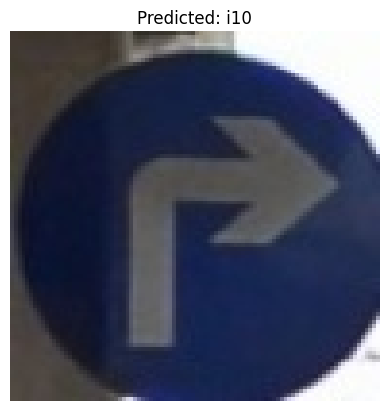

In [9]:
# === Load model MobileNetV2 đã train ===
model_name = "mobilenetv2"
model_path = f"/home/pi5/TrafficSign/WeightClassify/{model_name}_best.pth"
model = load_model(model_path, model_name, num_classes, device="cpu")

# === Chọn 1 ảnh test bất kỳ ===
sample_img = "/home/pi5/TrafficSign/Dataset/Classify/test/i10/32321_0.jpg"
# === Inference thử ===
infer_image(model, sample_img, mean, std, topk=3, device="cpu")


# Hardware infomation

In [9]:
!echo "=== CPU ===" > /kaggle/working/env_summary.txt
!lscpu >> /kaggle/working/env_summary.txt
!echo "\n=== RAM ===" >> /kaggle/working/env_summary.txt
!free -h >> /kaggle/working/env_summary.txt
!echo "\n=== DISK ===" >> /kaggle/working/env_summary.txt
!df -h >> /kaggle/working/env_summary.txt
!echo "\n=== GPU ===" >> /kaggle/working/env_summary.txt
!nvidia-smi >> /kaggle/working/env_summary.txt
!echo "\n=== OS ===" >> /kaggle/working/env_summary.txt
!uname -a >> /kaggle/working/env_summary.txt
!cat /etc/os-release >> /kaggle/working/env_summary.txt
!echo "\n=== Python ===" >> /kaggle/working/env_summary.txt
!python --version >> /kaggle/working/env_summary.txt
!pip list | head -n 50 >> /kaggle/working/env_summary.txt

!head -n 40 /kaggle/working/env_summary.txt


/bin/bash: line 1: nvidia-smi: command not found
ERROR: Pipe to stdout was broken
Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='utf-8'>
BrokenPipeError: [Errno 32] Broken pipe
=== CPU ===
Architecture:                         x86_64
CPU op-mode(s):                       32-bit, 64-bit
Address sizes:                        46 bits physical, 48 bits virtual
Byte Order:                           Little Endian
CPU(s):                               4
On-line CPU(s) list:                  0-3
Vendor ID:                            GenuineIntel
Model name:                           Intel(R) Xeon(R) CPU @ 2.20GHz
CPU family:                           6
Model:                                79
Thread(s) per core:                   2
Core(s) per socket:                   2
Socket(s):                            1
Stepping:                             0
BogoMIPS:                             4400.47
Flags:                                fpu vme de pse tsc msr pae mce cx